# Charm Analysis:

This analysis is done using `Coffea` (version 2024.10.0) and `Awkward Arrays`. This study will focus on the event selection of W+c Events. This analysis will focus on the selection of W+c Events for c-tagging study. The dataset used for this is: [W1JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL16NanoAODv9-106X_mcRun2_asymptotic_v17-v1/NANOAODSIM](https://opendata.cern.ch/record/69545).

In [1]:
import hist as h
import dask
import awkward as ak
import hist.dask as dhist
import dask_awkward as dak
import uproot
import numpy as np
import mplhep as mh
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import candidate
from coffea.dataset_tools import apply_to_fileset, preprocess
from matplotlib import pyplot as plt

In [2]:
events = NanoEventsFactory.from_root(
    {"../../datasets/nano106X_on_mini106X_2017_mc_NANOAOD_W1Jets_to_LNu_250K.root": "Events"},
    schemaclass=NanoAODSchema,
    metadata={"dataset":"WJets"},
    mode="dask"
).events()
events

/home/xondikoi/miniconda3/envs/Coffea_2025/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/home/xondikoi/miniconda3/envs/Coffea_2025/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/home/xondikoi/miniconda3/envs/Coffea_2025/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


dask.awkward<from-uproot, npartitions=1>

In [3]:
# Defining the style for plots (CMS Style)
plt.style.use(mh.style.CMS)
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14
})

# Histogram Function:
def make_hist(data, nBins, lo, hi, xLabel, yLabel, label, fname=None, logy=False):
    histogram = dhist.Hist(h.axis.Regular(nBins, lo, hi))
    fig, ax = plt.subplots(1 ,1, figsize=(6,4))
    histogram.fill(data)
    # histogram.compute().plot(ax=ax , yerr=False, label=label)  
    mh.histplot(histogram.compute(), ax=ax, label=label, yerr=False, histtype="step") 
    mh.cms.label("Open Data", data=True, lumi=None, com=13, year=2016, loc=0)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.legend()
    if logy:
        ax.set_yscale("log")
    if fname:
        plt.savefig(fname)
    plt.show()

## W $\rightarrow$ $\mu + \nu$ Event Selection:

This part of the notebook selects all the events that pass the following cuts:
- Muon $p_{T}$ > 35 GeV
- Muon $\eta$ < 2.4
- Muon_pfRelIso04_all < 0.15
- $M_{T}$ > 55 GeV

`Muon_pfRelIso04_all` represents the relative isolation of a reconstructed muon within the cone radius of $\Delta R$ = 0.4 around the muon. Higher value suggests the muon is likely from a jet (muon is not isolated) and lower value suggests the muon is likely from a $W/Z$ decay. 

In [4]:
# RecoMuons and MET:
RecoMuons = events.Muon
MET = events.MET

# Muon Selection Cuts: 
Selection_Cuts = (
    (RecoMuons.pt > 35) &
    (abs(RecoMuons.eta) < 2.4) &
    (abs(RecoMuons.pfRelIso04_all) < 0.15) &
    (RecoMuons.tightId == 1)
)

# M_T Selection Cut:
Muon_Mt = np.sqrt(2 * RecoMuons.pt * MET.pt * (1 - np.cos(RecoMuons.phi - MET.phi)))
Selection_Cuts = Selection_Cuts & (Muon_Mt > 55)
Muons_Sel = RecoMuons[Selection_Cuts]

# Leading Muon Collection and Transverse Momentum:
Leading_Muons = dak.firsts(Muons_Sel)
none_val_mask = dak.is_none(Leading_Muons.pt) # all None values
Leading_Muons_Clean = Leading_Muons[~none_val_mask] # discard all none values
Leading_Muons_Clean_Pt = Leading_Muons_Clean.pt

# Number of Sorted Muons & passCuts for OS:
nMuons = dak.num(Muons_Sel)

# Sub-Leading Muon Collection and Transverse Momentum:
sublead_mask = nMuons > 1
Subleading_Muons = Muons_Sel[sublead_mask][:,1]

OS_mask = (ak.sum(Muons_Sel.charge, axis=1) == 0) | (nMuons >=2) 
Selected_Muons_PassCuts = ~OS_mask 
 # Final Selection of Muons:
fMuons = Muons_Sel[Selected_Muons_PassCuts]

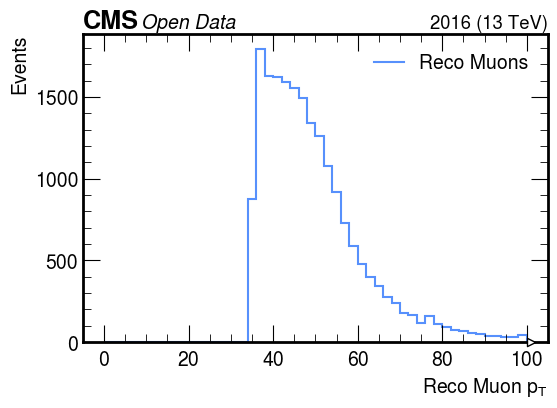

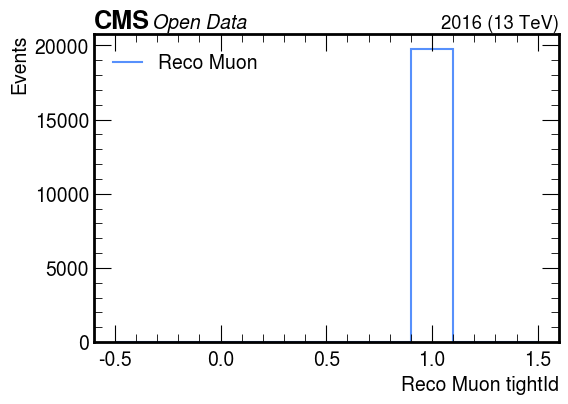

In [5]:
Muon_sel_pt = dak.flatten(Muons_Sel.pt)
make_hist(
    Muon_sel_pt,
    50, 0, 100,
    "Reco Muon $p_{T}$",
    "Events",
    "Reco Muons",
    fname=None,
    logy=False
)
Muon_sel_tightId = dak.flatten(Muons_Sel.tightId)
make_hist(
    Muon_sel_tightId,
    10, -0.5, 1.5,
    "Reco Muon tightId",
    "Events",
    "Reco Muon",
    fname=None,
    logy=False
)

> **Note:** The cuts of $p_{T}$ > 35 GeV and the `Muon_tightId` == 1 gives us perfect cuts. But there is a strange thing that happens with the selection cuts applied to the next part!

Here I am trying to make a selection of all the events that pass the above selection cuts rather than making a singular physics object collection like - RecoMuons that pass the selection cuts.

In [6]:
# Let's see if we can do this in another way:
Sel_Cuts = (
    (events.Muon.pt > 35) &
    (abs(events.Muon.eta) < 2.4) &
    (abs(events.Muon.pfRelIso04_all) < 0.15) &
    (events.Muon.tightId == 1)
)
Mu_Mt = np.sqrt(2 * events.Muon.pt * events.MET.pt * (1 - np.cos(events.Muon.phi - events.MET.phi)))
Sel_Cuts = Sel_Cuts & (Mu_Mt > 55)
Sel_Cuts = dak.any(Sel_Cuts, axis=1)
pass_events = events[Sel_Cuts]

# Leading Muon Collection and Transverse Momentum:
Leading_Muons = dak.firsts(pass_events.Muon)
none_val_mask = dak.is_none(Leading_Muons.pt) # all None values
Leading_Muons_Clean = Leading_Muons[~none_val_mask] # discard all none values
Leading_Muons_Clean_Pt = Leading_Muons_Clean.pt

# Pt of Muon passing the cuts:
pass_events_Muon_Pt = pass_events.Muon.pt

# Number of Muons passing the cuts:
nPassMuons = dak.num(pass_events_Muon_Pt)
Muon_charge = pass_events.Muon.charge
OS_Mask = (
    (dak.sum(Muon_charge, axis=1) == 0) |
    (nPassMuons >= 2)
    )
finMask = ~OS_Mask
WBoson_Events = pass_events[finMask]

I want to make some comparison between: 
- Standalone physics object collection: `fMuons` and
- Collection of all events that pass the event selection cuts for W-Bosons: `WBoson_Events`

In the `fMuons` collection, there are 21520 events that pass the selection cuts out of 250K, while in the `WBoson_Events`, 19256 events passed the selection cuts. 

## Plots: `fMuons` vs `WBoson_Events`:

I will make plots of the following quantites of `fMuons` and `WBoson_Events` to see the difference between them:
- **nPassMuons**: The number of muons passing the kinematic selection cuts.
- **fin_nPassMuons**: The number of muons passing the final selection cuts.

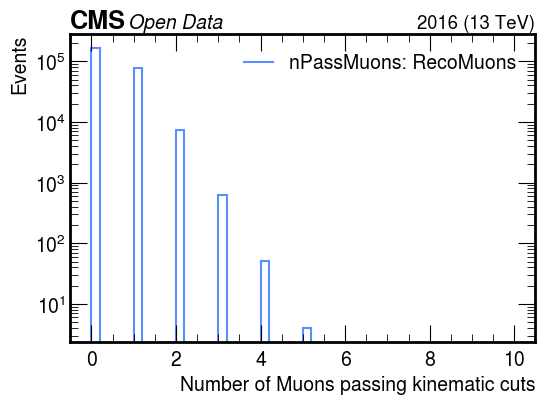

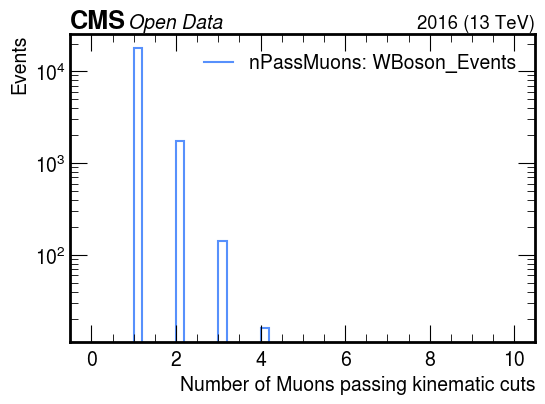

In [7]:
# Number of Muons before any Selection cuts: 
nRecoMuons = dak.num(RecoMuons.pt)
make_hist(
    nRecoMuons,
    50, 0, 10,
    "Number of Muons passing kinematic cuts",
    "Events",
    "nPassMuons: RecoMuons",
    fname="Plots/nPassMuons_RecoMuons.png",
    logy=True
)

# WBoson_Events
make_hist(
    nPassMuons,
    50, 0, 10,
    "Number of Muons passing kinematic cuts",
    "Events",
    "nPassMuons: WBoson_Events",
    fname="Plots/nPassMuons_WBoson_Events.png",
    logy=True
)

Let us also plot the kinematic observables of RecoMuons from the collection: `WBoson_Events`.

## Without any Kinematic Cuts:
- Muon $p_{T}$
- Muon $\eta$
- Muon $\phi$
- Muon_pfRelIso04_all
- Muon_TightID

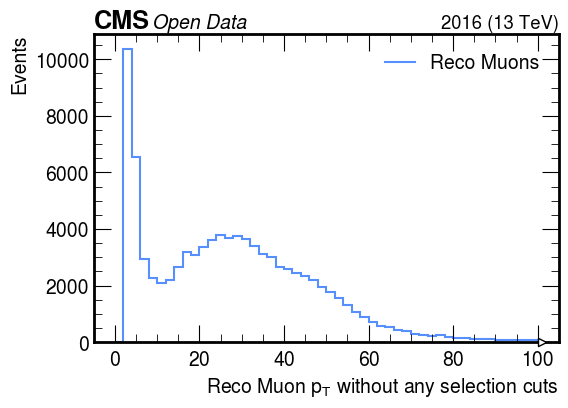

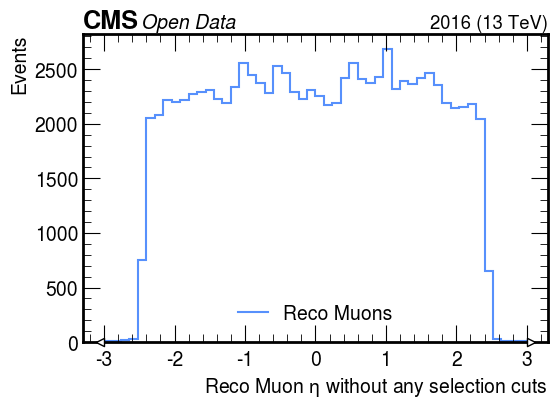

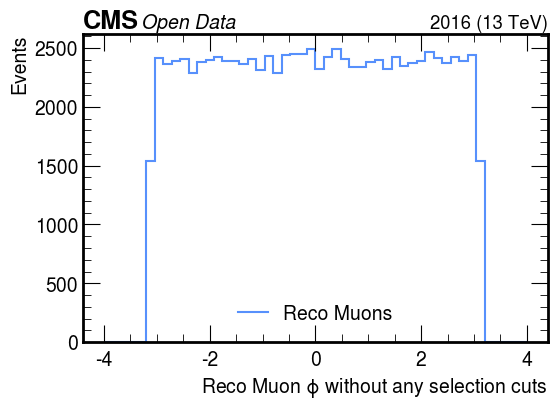

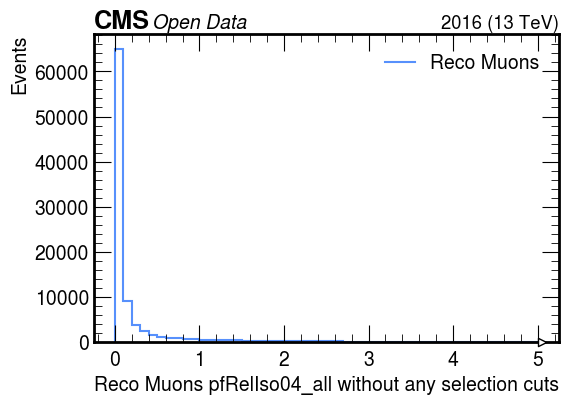

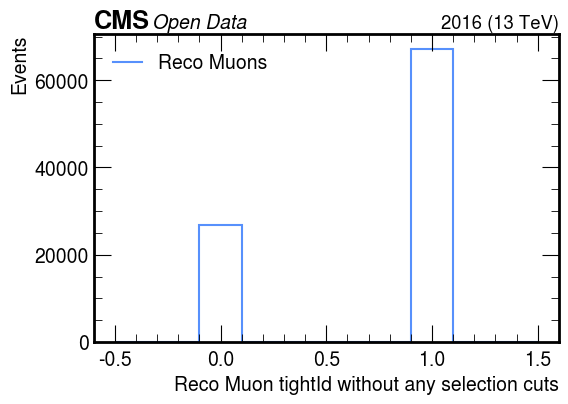

In [8]:
# Muon Pt (without cuts):
Pass_Muon_Pt = dak.flatten(events.Muon.pt)
make_hist(
    Pass_Muon_Pt,
    50, 0, 100,
    "Reco Muon $p_{T}$ without any selection cuts",
    "Events",
    "Reco Muons",
    fname="Plots/WBoson_RecoMuon_Pt.png",
    logy=False
)
# Muon eta (without cuts):
Pass_Muon_Eta = dak.flatten(events.Muon.eta)
make_hist(
    Pass_Muon_Eta,
    50, -3, 3,
    "Reco Muon $\\eta$ without any selection cuts",
    "Events",
    "Reco Muons",
    fname="Plots/WBoson_RecoMuon_Eta.png",
    logy=False
)
# Muon Phi (without cuts):
Pass_Muon_Phi = dak.flatten(events.Muon.phi)
make_hist(
    Pass_Muon_Phi,
    50, -4, 4,
    "Reco Muon $\\phi$ without any selection cuts",
    "Events",
    "Reco Muons",
    fname="Plots/WBoson_RecoMuon_Phi.png",
    logy=False
)
# Muon pfRelIso04_all (without cuts):
Pass_Muon_pfRelIso04 = dak.flatten(events.Muon.pfRelIso04_all)
make_hist(
    Pass_Muon_pfRelIso04,
    50, 0, 5,
    "Reco Muons pfRelIso04_all without any selection cuts",
    "Events",
    "Reco Muons",
    fname="Plots/WBoson_RecoMuon_pfRelIso04_all.png"
)
# Muon TightID (without cuts):
Pass_Muon_tightId = dak.flatten(events.Muon.tightId)
make_hist(
    Pass_Muon_tightId,
    10, -0.5, 1.5,
    "Reco Muon tightId without any selection cuts",
    "Events",
    "Reco Muons",
    fname="Plots/WBoson_RecoMuon_tightId.png",
    logy=False
)

## With all Kinematic Cuts:
- Muon $p_{T}$
- Muon $\eta$
- Muon $\phi$
- Muon_pfRelIso04_all
- Muon_TightID

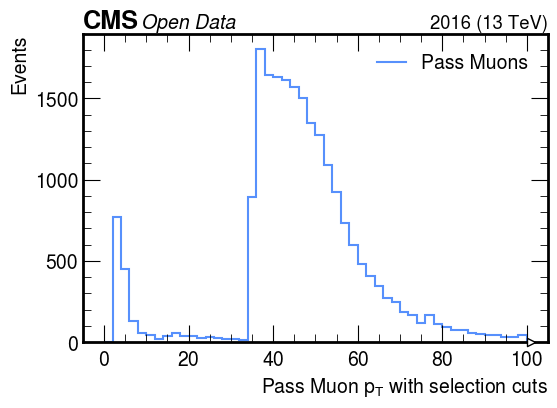

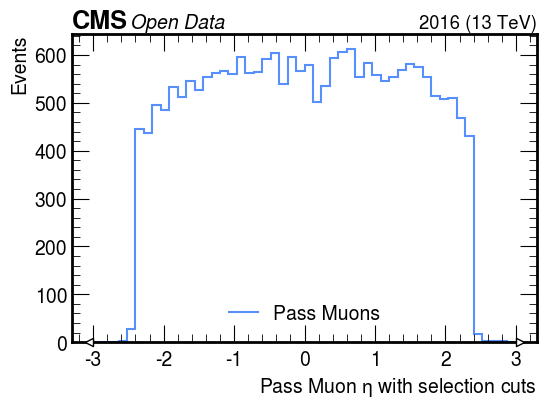

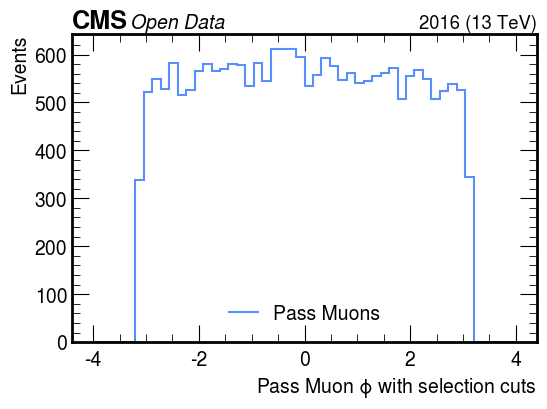

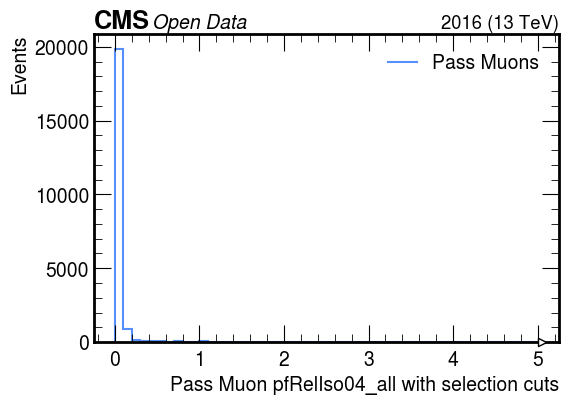

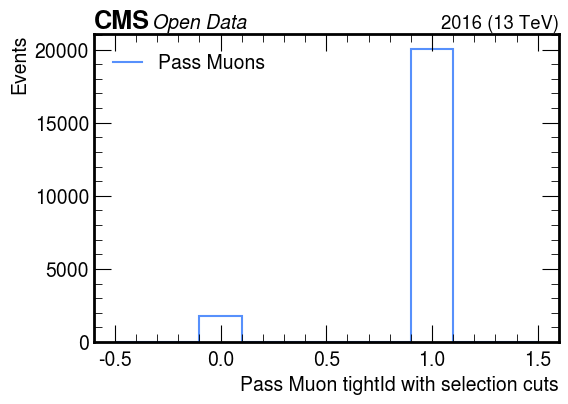

In [9]:
# Muon Pt (with cuts):
Pass_Muon_Pt = dak.flatten(pass_events.Muon.pt)
make_hist(
    Pass_Muon_Pt,
    50, 0, 100,
    "Pass Muon $p_{T}$ with selection cuts",
    "Events",
    "Pass Muons",
    fname="Plots/WBoson_PassMuon_Pt.png",
    logy=False
)
# Muon eta (with cuts):
Pass_Muon_Eta = dak.flatten(pass_events.Muon.eta)
make_hist(
    Pass_Muon_Eta,
    50, -3, 3,
    "Pass Muon $\\eta$ with selection cuts",
    "Events",
    "Pass Muons",
    fname="Plots/WBoson_PassMuon_Eta.png",
    logy=False
)
# Muon Phi (with cuts):
Pass_Muon_Phi = dak.flatten(pass_events.Muon.phi)
make_hist(
    Pass_Muon_Phi,
    50, -4, 4,
    "Pass Muon $\\phi$ with selection cuts",
    "Events",
    "Pass Muons",
    fname="Plots/WBoson_PassMuon_Phi.png",
    logy=False
)
# Muon pfRelIso04_all (with cuts):
Pass_Muon_pfRelIso04_all = dak.flatten(pass_events.Muon.pfRelIso04_all)
make_hist(
    Pass_Muon_pfRelIso04_all,
    50, 0, 5,
    "Pass Muon pfRelIso04_all with selection cuts",
    "Events",
    "Pass Muons",
    fname="Plots/WBoson_PassMuon_pfRelIso04_all.png",
    logy=False
)
# Muon tightID (with cuts):
Pass_Muon_tightId = dak.flatten(pass_events.Muon.tightId)
make_hist(
    Pass_Muon_tightId,
    10, -0.5, 1.5,
    "Pass Muon tightId with selection cuts",
    "Events",
    "Pass Muons",
    fname="Plots/WBoson_PassMuon_tightId.png",
    logy=False
)

> **Bug Issue:** Selection Cuts `Sel_Cuts` has an issue. Since, `Sel_Cuts` is jagged boolean mask, so one needs to do `dak.any(Sel_Cuts, axis=1)`. But this makes the Selection cuts not work properly. But after the final selection cuts are done ,i.e. `~OS_Mask` is applied, the cuts work perfectly fine. The occurence of this issue is not understood and needs to be resolved.

## Final Selection with all Kinematic Cuts:
- Muon $p_{T}$
- Muon $\eta$
- Muon $\phi$
- Muon_pfRelIso04_all
- Muon_TightID

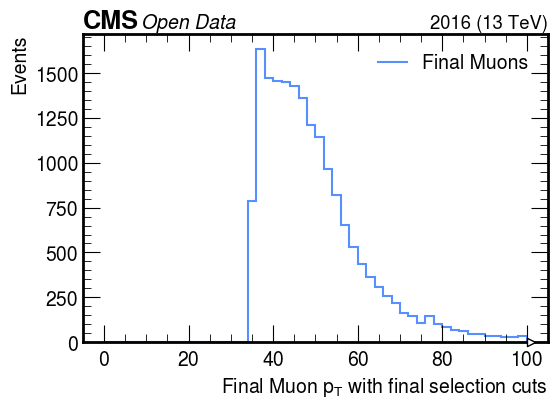

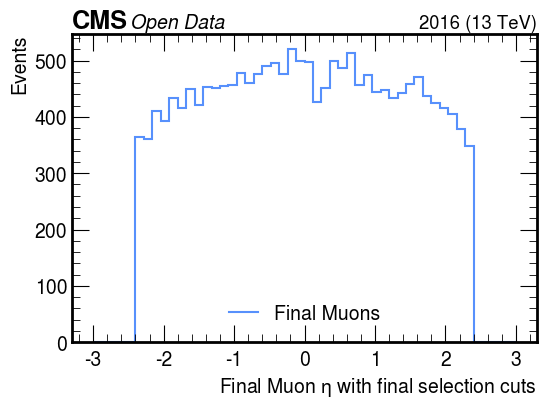

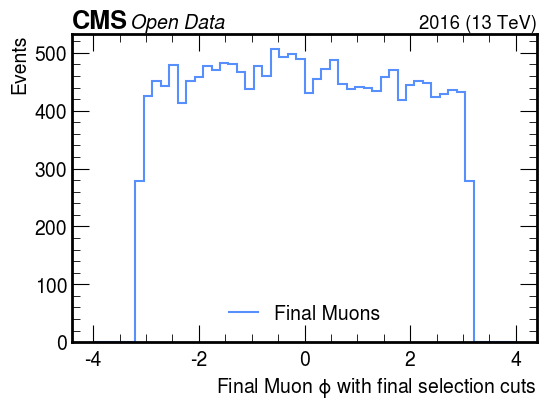

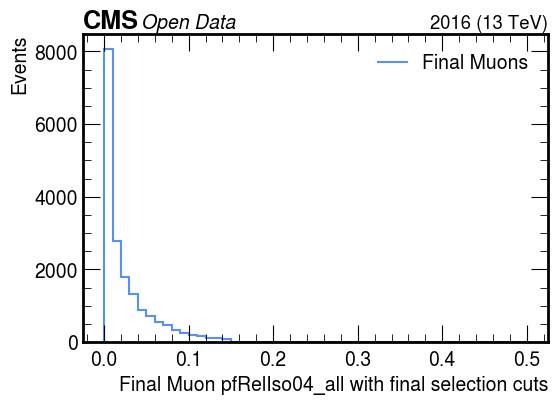

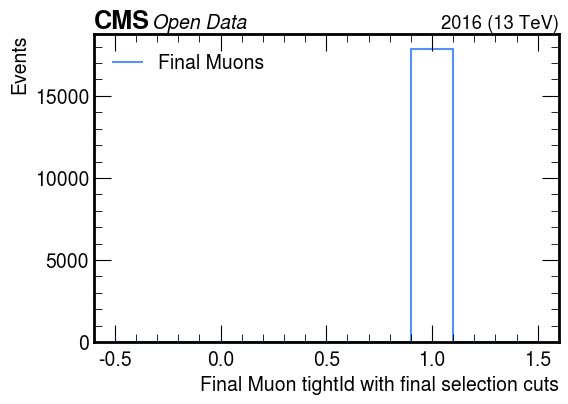

In [10]:
# Muon Pt (with cuts):
WBos_Pass_Muon_Pt = dak.flatten(WBoson_Events.Muon.pt)
make_hist(
    WBos_Pass_Muon_Pt,
    50, 0, 100,
    "Final Muon $p_{T}$ with final selection cuts",
    "Events",
    "Final Muons",
    fname="Plots/WBoson_FinalMuon_Pt.png",
    logy=False
)
# Muon eta (with cuts):
WBos_Muon_Eta = dak.flatten(WBoson_Events.Muon.eta)
make_hist(
    WBos_Muon_Eta,
    50, -3, 3,
    "Final Muon $\\eta$ with final selection cuts",
    "Events",
    "Final Muons",
    fname="Plots/WBoson_FinalMuon_Eta.png",
    logy=False
)
# Muon Phi (with cuts):
WBos_Muon_Phi = dak.flatten(WBoson_Events.Muon.phi)
make_hist(
    WBos_Muon_Phi,
    50, -4, 4,
    "Final Muon $\\phi$ with final selection cuts",
    "Events",
    "Final Muons",
    fname="Plots/WBoson_FinalMuon_Phi.png",
    logy=False
)
# Muon pfRelIso04_all (with cuts):
WBos_Muon_pfRelIso04 = dak.flatten(WBoson_Events.Muon.pfRelIso04_all)
make_hist(
    WBos_Muon_pfRelIso04,
    50, 0, 0.5,
    "Final Muon pfRelIso04_all with final selection cuts",
    "Events",
    "Final Muons",
    fname="Plots/WBoson_FinalMuon_pfRelIso04_all.png",
    logy=False
)
# Muon tightId (with cuts):
WBos_Muon_tightId = dak.flatten(WBoson_Events.Muon.tightId)
make_hist(
    WBos_Muon_tightId,
    10, -0.5, 1.5,
    "Final Muon tightId with final selection cuts",
    "Events",
    "Final Muons",
    fname="Plots/WBoson_FinalMuon_tightId.png",
    logy=False
)

## Number of Final Selected Muons:
This plot is the number of all selected muons and should only have the events with a single muon.

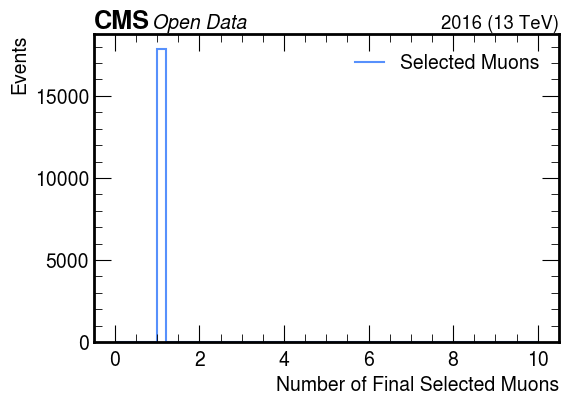

In [11]:
# Plot the number of Muons Final:
WBos_Muon_Pt = WBoson_Events.Muon.pt
nPassMu = dak.num(WBos_Muon_Pt)
make_hist(
    nPassMu,
    50, 0, 10,
    "Number of Final Selected Muons",
    "Events",
    "Selected Muons",
    fname=None,
    logy=False
)

All events passing these muon selections for W Bosons need to be stored now, so that we can do the **OS - SS** selection.

## c $\rightarrow$ $\mu$ + Anything Event Selection:

This part of the notebook selects all the events that pass the following cuts:
- Jet $p_{T}$ > 30 GeV
- Jet $\eta$ < 2.4
- Muon $p_{T}$ < 25 GeV
- Muon $\eta$ < 2.4
- Muon_pfRelIso04_all > 0.2
- Muon_jetIdx >=0
- Dimuon invariant mass 20 GeV < Inv_Mass $\mu^{+}\mu^{-}$ < 80 GeV.  

In [59]:
# RecoJet Collection:
RecoJets = events.Jet

# Jet Selection Cuts:
Jet_PassCuts = (
    (abs(RecoJets.eta) < 2.4) &
    (RecoJets.pt > 30)
)
selCuts_jet = dak.any(Jet_PassCuts, axis=1)
pass_events_Jets = events[selCuts_jet]

RecoMuons = pass_events_Jets.Muon

# Muon Selection Cuts:
Muon_PassCuts = (
    (abs(RecoMuons.eta) < 2.4) &
    (RecoMuons.pt < 25) &
    (abs(RecoMuons.pfRelIso04_all) > 0.2) &
    (RecoMuons.jetIdx >= 0)
)
selCuts_Muon = dak.any(Muon_PassCuts, axis=1)
pass_events_Muons = pass_events_Jets[selCuts_Muon]

# Jet Muons:
Jet_Muons = pass_events_Muons.Muon

# Dimuon Mass:
Jet_Muons_Padded = dak.pad_none(Jet_Muons, 2, axis=1)
valid_mask = ~dak.is_none(Jet_Muons_Padded[:,0]) & ~dak.is_none(Jet_Muons_Padded[:,1])
dimuon_events = Jet_Muons_Padded[valid_mask]

# Dimuon mass:
dimuon_mass = (dimuon_events[:,0] + dimuon_events[:,1]).mass

# Dimuon mass cut:
mass_Cut = (
    (dimuon_mass > 20) &
    (dimuon_mass < 80)
    )
final_Cut = mass_Cut
Jet_Events = pass_events_Jets[final_Cut]

Plotting the Number of Selected Muons:

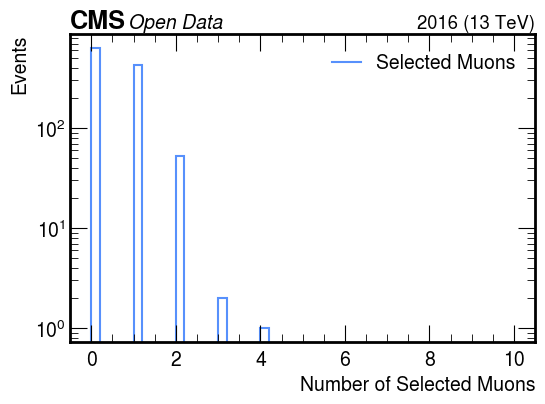

In [62]:
Selected_Muons = Jet_Events.Muon
Selected_Muons_Pt = Selected_Muons.pt
# Number of Muons:
nSelMuons = dak.num(Selected_Muons_Pt)
make_hist(
    nSelMuons,
    50, 0, 10,
    "Number of Selected Muons",
    "Events",
    "Selected Muons",
    fname=None,
    logy=True
)

Plotting the dimuon invariant mass (without putting cuts):

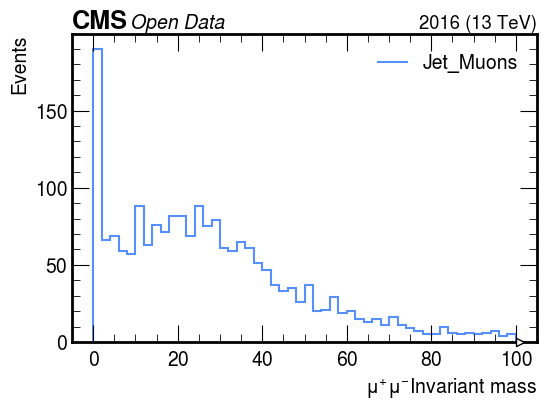

In [63]:
make_hist(
    dimuon_mass,
    50, 0, 100,
    "$\\mu^{+} \\mu^{-}$Invariant mass",
    "Events",
    "Jet_Muons",
    fname=None,
    logy=False
)

Plotting all the kinematic variables before the cut is put:

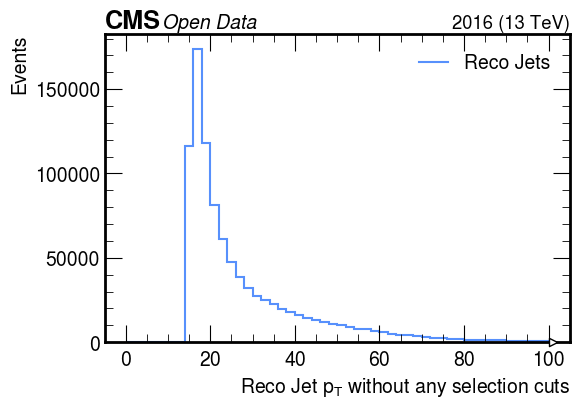

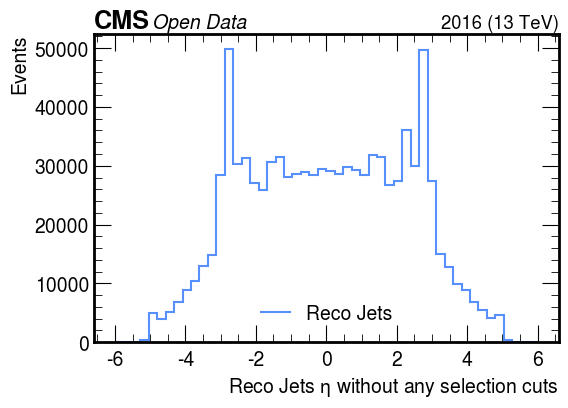

In [ ]:
# RecoJet Pt (without cut):
RecoJets_Pt = dak.flatten(RecoJets.pt)
make_hist(
    RecoJets_Pt,
    50, 0, 100,
    "Reco Jet $p_{T}$ without any selection cuts",
    "Events",
    "Reco Jets",
    fname="Plots/RecoJets_pT.png",
    logy=False
) 

# RecoJet Eta (without cut):
RecoJets_eta = dak.flatten(RecoJets.eta)
make_hist(
    RecoJets_eta,
    50, -6, 6,
    "Reco Jets $\\eta$ without any selection cuts",
    "Events",
    "Reco Jets",
    fname="Plots/RecoJets_eta.png",
    logy=False
)

Plotting all the kinematic variables after the cut is put:

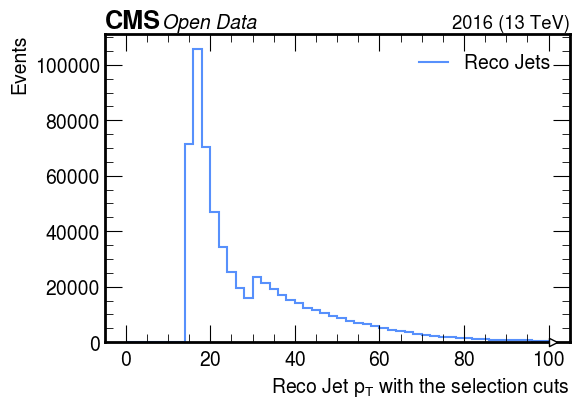

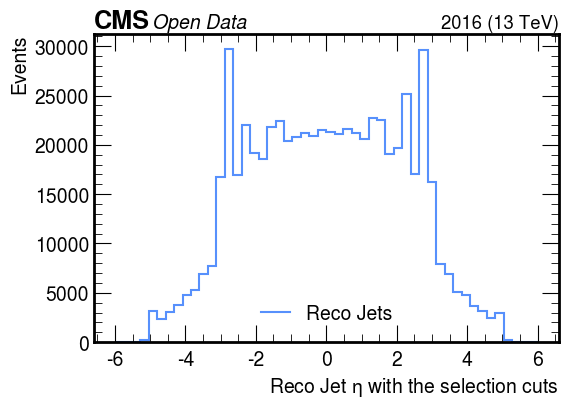

In [76]:
# RecoJet Pt (with cut):
pass_events_Jets_Pt = dak.flatten(pass_events_Jets.Jet.pt)
make_hist(
    pass_events_Jets_Pt,
    50, 0, 100,
    "Reco Jet $p_{T}$ with the selection cuts",
    "Events",
    "Reco Jets",
    fname="Plots/RecoJets_pass_pT.png",
    logy=False
)
# RecoJet Eta (with cut):
pass_events_Jets_eta = dak.flatten(pass_events_Jets.Jet.eta)
make_hist(
    pass_events_Jets_eta,
    50, -6, 6,
    "Reco Jet $\\eta$ with the selection cuts",
    "Events",
    "Reco Jets",
    fname="Plots/RecoJets_pass_eta.png",
    logy=False
)

Plotting the final selected Jet and Muons:

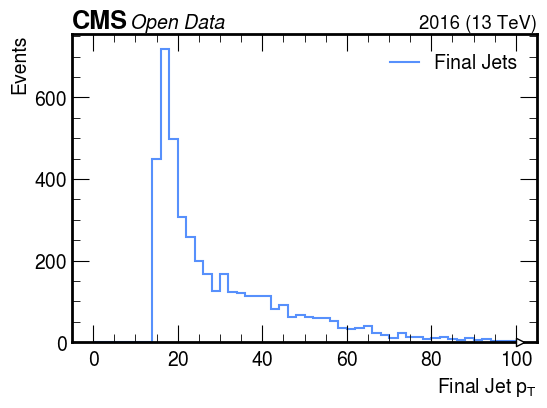

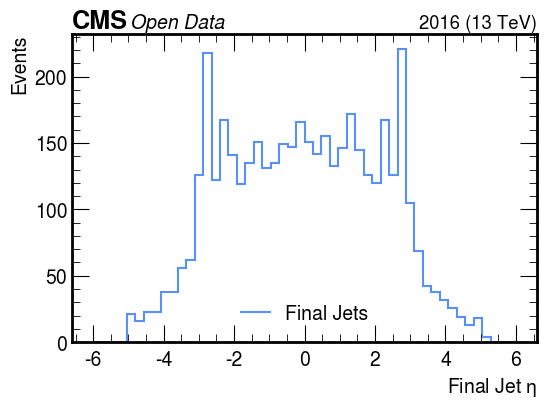

In [78]:
# Jet Pt with final cuts:
Final_Jet_Pt = dak.flatten(Jet_Events.Jet.pt)
make_hist(
    Final_Jet_Pt,
    50, 0, 100,
    "Final Jet $p_{T}$",
    "Events",
    "Final Jets",
    fname="Plots/FinalJet_pT.png",
    logy=False
)

# Jet eta with final cuts:
Final_Jet_eta = dak.flatten(Jet_Events.Jet.eta)
make_hist(
    Final_Jet_eta,
    50, -6, 6,
    "Final Jet $\\eta$",
    "Events",
    "Final Jets",
    fname="Plots/FinalJet_eta.png",
    logy=False
)

## OS - SS Analysis (Signal Extraction):

In [64]:
# OS events: Signal-like & SS events: Background-like: